--2024-11-26 00:14:54--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar.8’

navec_hudlit_v1_12B 100%[===================>]  50.56M  45.5MB/s    in 1.1s    

2024-11-26 00:14:55 (45.5 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar.8’ saved [53012480/53012480]

error:  cannot create ./dataset/poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
error:  cannot create ./dataset/prose/Gogol/╨Я╨╛╨▓╨╡╤Б╤В╤М ╨╛ ╤В╨╛╨╝, ╨║╨░╨║ ╨┐╨╛╤Б╤Б╨╛╤А╨╕╨╗╤Б╤П ╨Ш╨▓╨░╨╜ ╨Ш╨▓╨░╨╜╨╛╨▓╨╕╤З ╤Б ╨Ш╨▓╨░╨╜╨╛╨╝ ╨Э╨╕╨║╨╕╤Д╨╛╤А╨╛╨▓╨╕╤З╨╡╨╝.txt
        File n

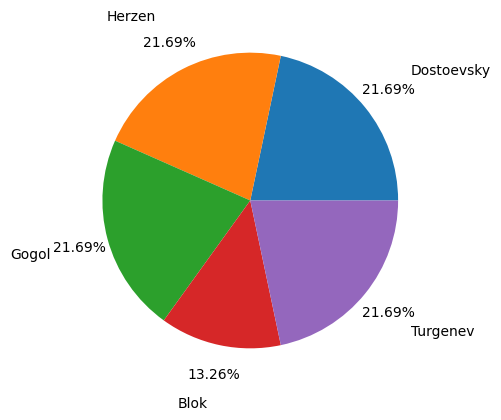

Форма входных данных для обучающей выборки: (4105, 1000)
Форма выходных данных (меток) для обучающей выборки: (4105, 5)
Форма входных данных для тестовой выборки: (416, 1000)
Форма выходных данных (меток) для тестовой выборки: (416, 5)
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 239ms/step - accuracy: 0.2143 - loss: 2.0514 - val_accuracy: 0.2572 - val_loss: 1.5914
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.2288 - loss: 1.8693 - val_accuracy: 0.2740 - val_loss: 1.5891
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.2432 - loss: 1.7951 - val_accuracy: 0.2188 - val_loss: 1.5883
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.2637 - loss: 1.7244 - val_accuracy: 0.2188 - val_loss: 1.5878
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.2679 - loss: 1.6982 - val_accuracy: 0.2188 - val_loss: 1.5795
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.3140 - loss: 1.6082 - val_accuracy: 0.2236 - val_loss

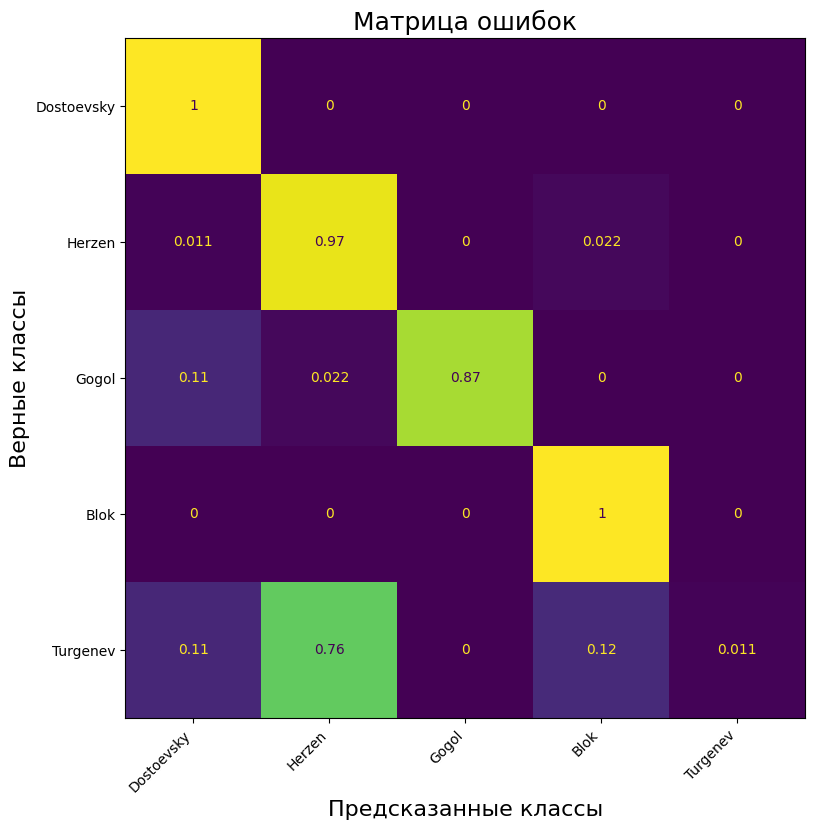


Средняя точность распознавания:  77%


In [ ]:
# Установка библиотеки Navec
!pip install navec

# Загрузка модели Navec
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
from navec import Navec
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

# Импорт необходимых библиотек
import keras
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout, LSTM, GRU, Bidirectional
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка данных
data_path = keras.utils.get_file("russian_literature.zip", "https://storage.yandexcloud.net/academy.ai/russian_literature.zip")
!unzip -qo "{data_path}" -d ./dataset

# Список писателей
CLASS_LIST = ["Dostoevsky", "Herzen", "Gogol", "Blok", "Turgenev"]

# Собираем датасет
all_texts = {}

for author in CLASS_LIST:
    all_texts[author] = ''
    for path in glob.glob(f'./dataset/prose/{author}/*.txt') + glob.glob(f'./dataset/poems/{author}/*.txt'):
        with open(path, 'r', errors='ignore') as f:
            text = f.read()
        all_texts[author] += ' ' + text.replace('\n', ' ')

# Токенизация текста
embedding_dim = 300
max_words = 10000

tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-–—./…:;<=>?@[\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(all_texts.values())

seq_train = tokenizer.texts_to_sequences(all_texts.values())
seq_train_balance = [seq_train[cls][:100_000] for cls in range(len(CLASS_LIST))]

# Вывод информации о датасете
total = sum(len(i) for i in seq_train)
print(f'Датасет состоит из {total} слов')

mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

# Визуализация распределения данных
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance], labels=CLASS_LIST, pctdistance=1.2, labeldistance=1.4, autopct='%1.2f%%')
plt.show()

# Определение параметров для скользящего окна
WIN_SIZE = 1000
WIN_STEP = 100

# Функция разбиения последовательности на отрезки скользящим окном
def seq_split(sequence, win_size, step):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

# Функция векторизации последовательности
def seq_vectorize(seq_list, test_split, class_list, win_size, step):
    x_train, y_train, x_test, y_test = [], [], [], []

    for class_item in class_list:
        cls = class_list.index(class_item)
        gate_split = int(len(seq_list[cls]) * (1 - test_split))
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step)
        vectors_test = seq_split(seq_list[cls][gate_split:], win_size, step)

        x_train += vectors_train
        x_test += vectors_test
        y_train += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_test)

    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

# Векторизация данных
x_train, y_train, x_test, y_test = seq_vectorize(seq_train_balance, 0.1, CLASS_LIST, WIN_SIZE, WIN_STEP)

print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток)для обучающей выборки: {y_train.shape}')
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

# Функция вывода графиков точности и ошибки
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'], label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'], label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода матрицы ошибок
def show_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), normalize='true')
    cm = np.around(cm, 3)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)
    plt.show()

    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

# Функция загрузки эмбеддингов
def loadEmbedding(model):
    word_index = tokenizer.word_index
    embeddings_index = navec

    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    # Убедитесь, что слой Embedding не имеет весов
    if model.layers[0].weights:
        model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    return model

# Создание модели
model_MIX = Sequential()
model_MIX.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model_MIX.add(SpatialDropout1D(0.3))
model_MIX.add(BatchNormalization())

# Два двунаправленных рекуррентных слоя LSTM
model_MIX.add(Bidirectional(LSTM(16, return_sequences=True)))
model_MIX.add(Bidirectional(LSTM(16, return_sequences=True)))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Два рекуррентных слоя GRU
model_MIX.add(GRU(32, return_sequences=True, reset_after=True))
model_MIX.add(GRU(32, reset_after=True))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Дополнительный полносвязный слой
model_MIX.add(Dense(256, activation='relu'))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())
model_MIX.add(Dense(len(CLASS_LIST), activation='softmax'))

# Загрузка эмбеддингов
model_MIX = loadEmbedding(model_MIX)

# Компиляция модели
model_MIX.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history_mix = model_MIX.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_test, y_test))

# Предсказание на тестовой выборке
y_pred_mix = model_MIX.predict(x_test)
show_confusion_matrix(y_test, y_pred_mix, CLASS_LIST)

